# Pix2Pix实现图像转换

## Pix2Pix概述

Pix2Pix是基于条件生成对抗网络（cGAN, Condition Generative Adversarial Networks ）实现的一种深度学习图像转换模型，该模型是由Phillip Isola等作者在2017年CVPR上提出的，可以实现语义/标签到真实图片、灰度图到彩色图、航空图到地图、白天到黑夜、线稿图到实物图的转换。Pix2Pix是将cGAN应用于有监督的图像到图像翻译的经典之作，其包括两个模型：**生成器**和**判别器**。

传统上，尽管此类任务的目标都是相同的从像素预测像素，但每项都是用单独的专用机器来处理的。而Pix2Pix使用的网络作为一个通用框架，使用相同的架构和目标，只在不同的数据上进行训练，即可得到令人满意的结果，鉴于此许多人已经使用此网络发布了他们自己的艺术作品。

## 基础原理

cGAN的生成器与传统GAN的生成器在原理上有一些区别，cGAN的生成器是将输入图片作为指导信息，由输入图像不断尝试生成用于迷惑判别器的“假”图像，由输入图像转换输出为相应“假”图像的本质是从像素到另一个像素的映射，而传统GAN的生成器是基于一个给定的随机噪声生成图像，输出图像通过其他约束条件控制生成，这是cGAN和GAN的在图像翻译任务中的差异。Pix2Pix中判别器的任务是判断从生成器输出的图像是真实的训练图像还是生成的“假”图像。在生成器与判别器的不断博弈过程中，模型会达到一个平衡点，生成器输出的图像与真实训练数据使得判别器刚好具有50%的概率判断正确。

在教程开始前，首先定义一些在整个过程中需要用到的符号：

- $x$：代表观测图像的数据。
- $z$：代表随机噪声的数据。
- $y=G(x,z)$：生成器网络，给出由观测图像$x$与随机噪声$z$生成的“假”图片，其中$x$来自于训练数据而非生成器。
- $D(x,G(x,z))$：判别器网络，给出图像判定为真实图像的概率，其中$x$来自于训练数据，$G(x,z)$来自于生成器。

cGAN的目标可以表示为：

$$L_{cGAN}(G,D)=E_{(x,y)}[log(D(x,y))]+E_{(x,z)}[log(1-D(x,G(x,z)))]$$

该公式是cGAN的损失函数，`D`想要尽最大努力去正确分类真实图像与“假”图像，也就是使参数$log D(x,y)$最大化；而`G`则尽最大努力用生成的“假”图像$y$欺骗`D`，避免被识破，也就是使参数$log(1−D(G(x,z)))$最小化。cGAN的目标可简化为：

$$arg\min_{G}\max_{D}L_{cGAN}(G,D)$$

![pix2pix1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/generative/images/pix2pix_1.png)

为了对比cGAN和GAN的不同，我们将GAN的目标也进行了说明：

$$L_{GAN}(G,D)=E_{y}[log(D(y))]+E_{(x,z)}[log(1-D(x,z))]$$

从公式可以看出，GAN直接由随机噪声$z$生成“假”图像，不借助观测图像$x$的任何信息。过去的经验告诉我们，GAN与传统损失混合使用是有好处的，判别器的任务不变，依旧是区分真实图像与“假”图像，但是生成器的任务不仅要欺骗判别器，还要在传统损失的基础上接近训练数据。假设cGAN与L1正则化混合使用，那么有:

$$L_{L1}(G)=E_{(x,y,z)}[||y-G(x,z)||_{1}]$$

进而得到最终目标：

$$arg\min_{G}\max_{D}L_{cGAN}(G,D)+\lambda L_{L1}(G)$$

图像转换问题本质上其实就是像素到像素的映射问题，Pix2Pix使用完全一样的网络结构和目标函数，仅更换不同的训练数据集就能分别实现以上的任务。本任务将借助MindSpore框架来实现Pix2Pix的应用。


## 创建网络

当处理完数据后，就可以来进行网络的搭建了。网络搭建将逐一详细讨论生成器、判别器和损失函数。生成器G用到的是U-Net结构，输入的轮廓图$x$编码再解码成真是图片，判别器D用到的是作者自己提出来的条件判别器PatchGAN，判别器D的作用是在轮廓图 $x$的条件下，对于生成的图片$G(x)$判断为假，对于真实判断为真。

### 生成器G结构

U-Net是德国Freiburg大学模式识别和图像处理组提出的一种全卷积结构。它分为两个部分，其中左侧是由卷积和降采样操作组成的压缩路径，右侧是由卷积和上采样组成的扩张路径，扩张的每个网络块的输入由上一层上采样的特征和压缩路径部分的特征拼接而成。网络模型整体是一个U形的结构，因此被叫做U-Net。和常见的先降采样到低维度，再升采样到原始分辨率的编解码结构的网络相比，U-Net的区别是加入skip-connection，对应的feature maps和decode之后的同样大小的feature maps按通道拼一起，用来保留不同分辨率下像素级的细节信息。

![pix2pix2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/generative/images/pix2pix_2.png)

#### 定义UNet Skip Connection Block

In [1]:
import mindspore
import mindspore.nn as nn
import mindspore.ops as ops

import time

a1 = time.time()

class UNetSkipConnectionBlock(nn.Cell):
    def __init__(self, outer_nc, inner_nc, in_planes=None, dropout=False,
                 submodule=None, outermost=False, innermost=False, alpha=0.2, norm_mode='batch'):
        super(UNetSkipConnectionBlock, self).__init__()
        down_norm = nn.BatchNorm2d(inner_nc)
        up_norm = nn.BatchNorm2d(outer_nc)
        use_bias = False
        if norm_mode == 'instance':
            down_norm = nn.BatchNorm2d(inner_nc, affine=False)
            up_norm = nn.BatchNorm2d(outer_nc, affine=False)
            use_bias = True
        if in_planes is None:
            in_planes = outer_nc
        down_conv = nn.Conv2d(in_planes, inner_nc, kernel_size=4,
                              stride=2, padding=1, has_bias=use_bias, pad_mode='pad')
        down_relu = nn.LeakyReLU(alpha)
        up_relu = nn.ReLU()
        if outermost:
            up_conv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, pad_mode='pad')
            down = [down_conv]
            up = [up_relu, up_conv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            up_conv = nn.Conv2dTranspose(inner_nc, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, has_bias=use_bias, pad_mode='pad')
            down = [down_relu, down_conv]
            up = [up_relu, up_conv, up_norm]
            model = down + up
        else:
            up_conv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                         kernel_size=4, stride=2,
                                         padding=1, has_bias=use_bias, pad_mode='pad')
            down = [down_relu, down_conv, down_norm]
            up = [up_relu, up_conv, up_norm]

            model = down + [submodule] + up
            if dropout:
                model.append(nn.Dropout(p=0.5))
        self.model = nn.SequentialCell(model)
        self.skip_connections = not outermost

    def construct(self, x):
        out = self.model(x)
        if self.skip_connections:
            out = ops.concat((out, x), axis=1)
        return out

[WARNING] ME(47136:281473664024592,MainProcess):2024-09-04-15:55:54.718.462 [mindspore/run_check/_check_version.py:357] MindSpore version 2.2.14 and Ascend AI software package (Ascend Data Center Solution)version 7.0 does not match, the version of software package expect one of ['7.1']. Please refer to the match info on: https://www.mindspore.cn/install
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
[WARNING] ME(47136:281473664024592,MainProcess):2024-09-04-15:55:57.420.05 [mindspore/run_check/_check_version.py:375] MindSpore version 2.2.14 and "te" wheel packa

#### 基于UNet的生成器

In [2]:
class UNetGenerator(nn.Cell):
    def __init__(self, in_planes, out_planes, ngf=64, n_layers=8, norm_mode='bn', dropout=False):
        super(UNetGenerator, self).__init__()
        unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=None,
                                             norm_mode=norm_mode, innermost=True)
        for _ in range(n_layers - 5):
            unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=unet_block,
                                                 norm_mode=norm_mode, dropout=dropout)
        unet_block = UNetSkipConnectionBlock(ngf * 4, ngf * 8, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf * 2, ngf * 4, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf, ngf * 2, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        self.model = UNetSkipConnectionBlock(out_planes, ngf, in_planes=in_planes, submodule=unet_block,
                                             outermost=True, norm_mode=norm_mode)

    def construct(self, x):
        return self.model(x)

原始cGAN的输入是条件x和噪声z两种信息，这里的生成器只使用了条件信息，因此不能生成多样性的结果。因此Pix2Pix在训练和测试时都使用了dropout，这样可以生成多样性的结果。

### 基于PatchGAN的判别器

判别器使用的PatchGAN结构，可看做卷积。生成的矩阵中的每个点代表原图的一小块区域（patch）。通过矩阵中的各个值来判断原图中对应每个Patch的真假。

In [4]:
import mindspore.nn as nn

class ConvNormRelu(nn.Cell):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size=4,
                 stride=2,
                 alpha=0.2,
                 norm_mode='batch',
                 pad_mode='CONSTANT',
                 use_relu=True,
                 padding=None):
        super(ConvNormRelu, self).__init__()
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if not padding:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad',
                             has_bias=has_bias, padding=padding)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad', has_bias=has_bias)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


### Pix2Pix的生成器初始化


In [6]:
import mindspore.nn as nn
from mindspore.common import initializer as init

g_in_planes = 3
g_out_planes = 3
g_ngf = 64
g_layers = 8
d_in_planes = 6
d_ndf = 64
d_layers = 3
alpha = 0.2
init_gain = 0.02
init_type = 'normal'


net_generator = UNetGenerator(in_planes=g_in_planes, out_planes=g_out_planes,
                              ngf=g_ngf, n_layers=g_layers)

for _, cell in net_generator.cells_and_names():
    if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
        if init_type == 'normal':
            cell.weight.set_data(init.initializer(init.Normal(init_gain), cell.weight.shape))
        elif init_type == 'xavier':
            cell.weight.set_data(init.initializer(init.XavierUniform(init_gain), cell.weight.shape))
        elif init_type == 'constant':
            cell.weight.set_data(init.initializer(0.001, cell.weight.shape))
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
    elif isinstance(cell, nn.BatchNorm2d):
        cell.gamma.set_data(init.initializer('ones', cell.gamma.shape))
        cell.beta.set_data(init.initializer('zeros', cell.beta.shape))

## 准备环节

### 准备数据

在本教程中，我们将使用[指定数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/dataset_pix2pix.tar)，该数据集是已经经过处理的外墙（facades）数据，可以直接使用mindspore.dataset的方法读取。

In [7]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/models/application/dataset_pix2pix.tar"

download(url, "./dataset", kind="tar", replace=True)


file_sizes: 100%|████████████████████████████| 881M/881M [01:06<00:00, 13.3MB/s]
Extracting tar file...
Successfully downloaded / unzipped to ./dataset


'./dataset'

### 数据展示

调用`Pix2PixDataset`和`create_train_dataset`读取训练集，这里我们直接下载已经处理好的数据集。

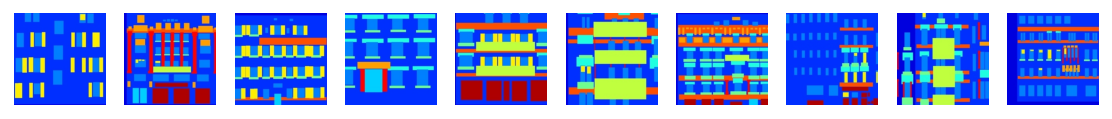

In [8]:
from mindspore import dataset as ds
import matplotlib.pyplot as plt

dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True)
data_iter = next(dataset.create_dict_iterator(output_numpy=True))
# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['input_images'][:10], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow((image.transpose(1, 2, 0) + 1) / 2)
plt.show()

## 推理

通过load_checkpoint和load_param_into_net将ckpt中的权重参数导入到模型中，获取数据进行推理并对推理的效果图进行演示。


file_sizes: 100%|████████████████████████████| 218M/218M [00:19<00:00, 11.3MB/s]
Successfully downloaded file to ./ckptGenerator_100.ckpt


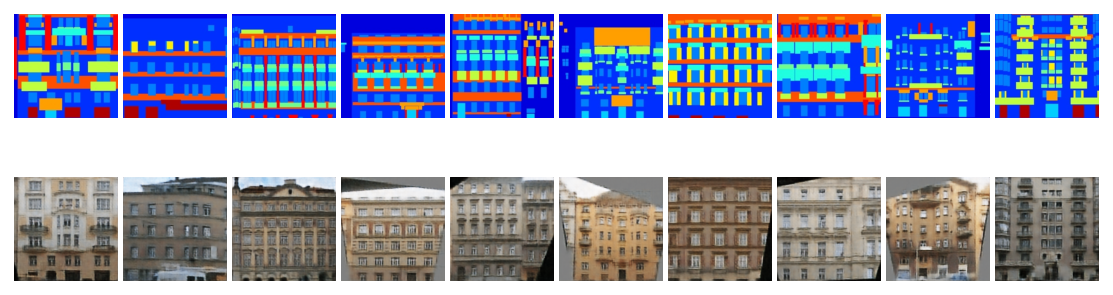

time:  571.1514880657196


In [10]:
import mindspore as ms
from mindspore import load_checkpoint, load_param_into_net


ms.set_context(max_device_memory="2GB", mode=ms.GRAPH_MODE, device_target="Ascend", jit_config={"jit_level":"O2"}, ascend_config={"precision_mode":"allow_mix_precision"})

# download ckpt
pix2pix_url = "https://mindspore-courses.obs.cn-north-4.myhuaweicloud.com/orange-pi-online-infer/11-Pix2Pix/ckptGenerator_100.ckpt"
path = "./ckptGenerator_100.ckpt"
ckpt_path = download(pix2pix_url, path, replace=True)

param_g = load_checkpoint(ckpt_path)
load_param_into_net(net_generator, param_g)
dataset = ds.MindDataset("./dataset/dataset_pix2pix/train.mindrecord", columns_list=["input_images", "target_images"], shuffle=True)
data_iter = next(dataset.create_dict_iterator())
predict_show = net_generator(data_iter["input_images"])
plt.figure(figsize=(10, 3), dpi=140)
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow((data_iter["input_images"][i].asnumpy().transpose(1, 2, 0) + 1) / 2)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
    plt.subplot(2, 10, i + 11)
    plt.imshow((predict_show[i].asnumpy().transpose(1, 2, 0) + 1) / 2)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.02)
plt.show()

a2 = time.time()

print("time: ", a2 -a1)


各数据集分别推理的效果如下

![pix2pix3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/generative/images/pix2pix_3.png)

## 引用

[1] Phillip Isola,Jun-Yan Zhu,Tinghui Zhou,Alexei A. Efros. Image-to-Image Translation with Conditional Adversarial Networks.[J]. CoRR,2016,abs/1611.07004.